# Tarea realizada por Carlos Sánchez Polo y Jesús Martínez Leal
Última edición: 28/02/2024

## Carga de librerías relevantes

In [3]:
#NumPy: numerical scientific computing 
import numpy as np

#Scikit-learn: machine learning
from sklearn.decomposition import PCA, KernelPCA

#Matplotlib: plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib notebook

#SciPy: scientific tools
import scipy.io.matlab as matlab

#OpenCV: computer vision
import cv2


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Carga de los datos

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser = 'auto')
X = MinMaxScaler().fit_transform(X)

Dividimos en train y test e introducimos ruido a las imágenes.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

# Representación de las imágenes

In [6]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

La siguiente función permite presentar dos bloques de números en paralelos para comparar. Por ejemplo las imágenes con ruido, y las imágenes tratadas para reducirlo.

In [7]:
def plot_parallel(X_clean, X_noisy, title_clean, title_noisy):
    """Small helper function to plot 100 digits."""
    # Creamos una figura más ancha para acomodar ambos conjuntos de datos
    fig, axs = plt.subplots(nrows=10, ncols=20, figsize=(10, 5)) 

    # Título y posición central para datos limpios
    axs[0, 4].set_title(title_clean, fontsize=10)

    # Título y posición central para datos ruidosos
    axs[0, 14].set_title(title_noisy, fontsize=10)

    for i in range(10):
        # Plot clean data
        for j, img in enumerate(X_clean[i*10:(i+1)*10]): # Los primeros 10 subplots para los datos limpios
            ax = axs[i, j]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

        # Plot noisy data
        for j, img in enumerate(X_noisy[i*10:(i+1)*10]): # Los siguientes 10 subplots para los datos ruidosos
            ax = axs[i, j+10]
            ax.imshow(img.reshape((16, 16)), cmap="Greys")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Vamos a usar el Mean Square Error (o error cuadrático medio) como medida del error. Cuando limpiemos las imágenes, tendremos que tener alguna referencia que nos permita de forma numérica saber si nuestras imágenes están mejor o peor que antes.

In [8]:
def calcular_mse(nuevas, originales=X_train):
    num_imagenes = len(originales)
    total_mse = 0.0

    for i in range(num_imagenes):
        mse = np.mean((originales[i] - nuevas[i])**2)
        total_mse += mse

    mse = total_mse / num_imagenes
    return mse

A continuación se ve los números originales y los números tras introducirles ruido

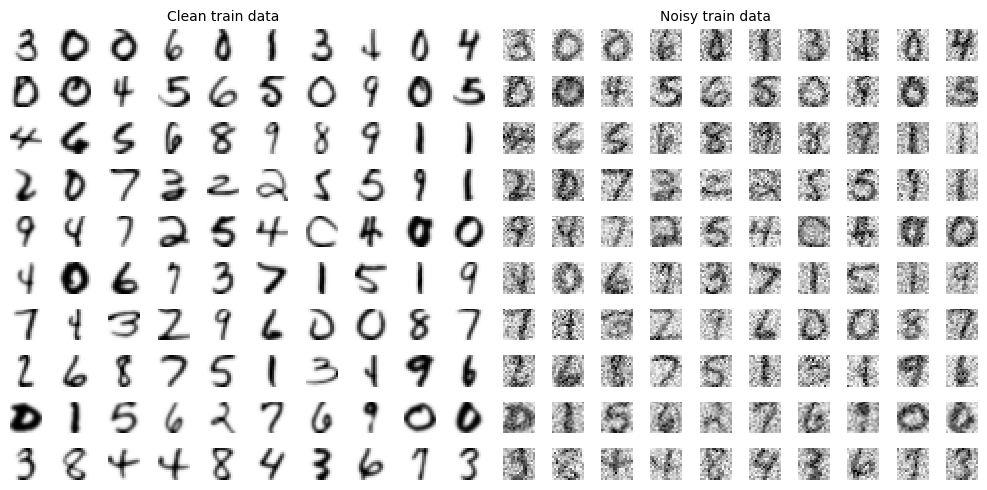

In [9]:
plot_parallel(X_train, X_train_noisy, "Clean train data", "Noisy train data")

# Ejercicio.

## Intenta quitar el ruido de las imágenes de test utilizando los métodos vistos en clase. Cuantifica los resultados cualitativamente y cuantitativamente utilizando MSE. Justifica todas tus respuestas.

Ajustar los hiperparámetros para obtener los mejores resultados posibles (número de componentes, tipo de kernel, gamma ...)

Hemos hecho varias pruebas previas para comprobar en qué rango de valores nos debemos mover para quitar el ruido a nuestras imágenes. 

El procedimiento es el siguiente: 

- Aplicamos KPCA, probando con distintos `kernel` y valores de `gamma`. Nos quedamos con el mejor denosing. 
- Sobre ese nuevo conjunto de imágenes procesadas volvemos a aplicar pca de forma iterativa hasta que el `MSE` alcance un mínimo. Para cada iteración nos guardamos los hiperparámetros de nuestro mejor modelo, que luego aplicaremos a nuestros datos de test, puesto que hasta habremos estado probando con los de entrenamiento.

El `kernel` = `linear` indica que se realiza la `PCA` convencional.

Con el objetivo de acelerar el tiempo de cálculo lo que haremos será paralelizar las iteraciones. Esto se consigue utilizando el módulo `joblib` con la clase `Paralell`.

### Etapas iniciales: fijación de semilla de aleatoriedad y definición de función para paralelizar

In [10]:
rs = 0

In [11]:
def evaluar_modelo(kernel, gamma, n_components, X):
    global best_mse
    
    kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components=n_components, fit_inverse_transform=True, random_state = rs).fit(X) 
    X_kpca = kpca.transform(X) 
    X_back = kpca.inverse_transform(X_kpca)
    
    mse = calcular_mse(nuevas=X_back)

    if mse < best_mse:
        best_mse = mse
        return kernel, gamma, n_components, mse
    else:
        return None

### Primer proceso de búsqueda de hiperparámetros

⚠️ ¡Atención! Ejecutar el chunk de código de abajo puede llevar a la CPU a un estado de utilización máxima.

In [12]:
from itertools import product
from joblib import Parallel, delayed

best_mse = calcular_mse(nuevas=X_train_noisy) # referencia para el MSE
recuento = 0

lista_gamma = np.arange(0.00125, 0.10001, 0.00125)
lista_n_components = [50, 100, 200]


results = Parallel(n_jobs=-1)(delayed(evaluar_modelo)(kernel, gamma, n_components, X = X_train_noisy)
                              for kernel, gamma, n_components in product(['rbf', 'poly', 'linear'], 
                                                                         lista_gamma, lista_n_components))

# Filtrar los resultados para excluir los valores None
results_filtered = [result for result in results if result is not None]

if results_filtered:
    best_result = min(results_filtered, key=lambda x: x[3])  # Encuentra el resultado con el menor MSE
    best_kernel, best_gamma, best_n_components, best_mse = best_result

    print("El mejor modelo tiene el siguiente kernel, gamma y n_components:") 
    print("Kernel:", best_kernel) 
    print("Gamma:", best_gamma) 
    print("n_components:", best_n_components) 
    print("MSE:", best_mse)
else:
    print("No se encontraron resultados válidos.")

El mejor modelo tiene el siguiente kernel, gamma y n_components:
Kernel: poly
Gamma: 0.01625
n_components: 50
MSE: 0.012724767871997915


Hemos probado 720 modelos y  seleccionado aquel cuyos hiperparámetros reducen más el MSE. Transformamos de forma definitiva nuestras imágenes con ruido usando este modelo seleccionado. Representamos las nuevas imágenes con mucho menor ruido:

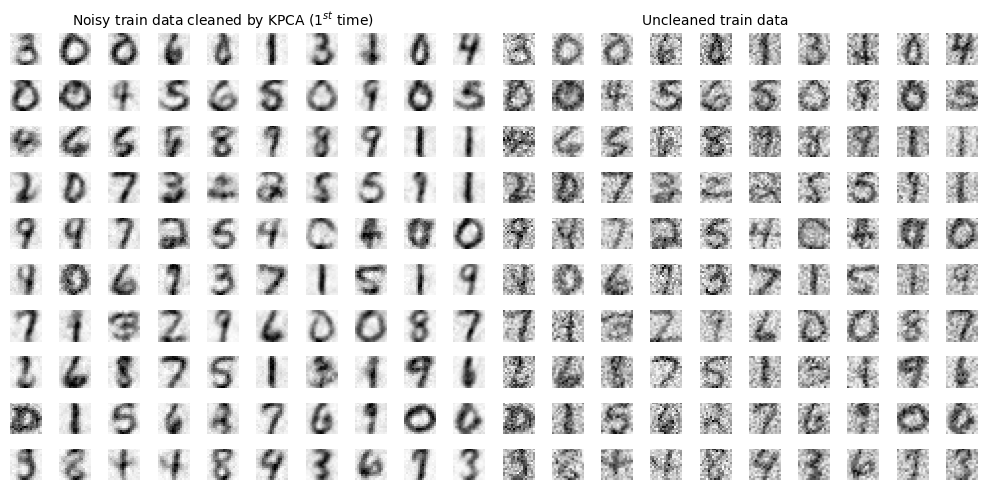

In [13]:
gamma = best_gamma
kernel = best_kernel
num_components = best_n_components

kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components = num_components, fit_inverse_transform=True).fit(X_train_noisy) 
X_kpca = kpca.transform(X_train_noisy) 
X_back_m1 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m1, X_train_noisy, "Noisy train data cleaned by KPCA ($1^{st}$ time)", "Uncleaned train data")

### Segundo proceso de búsqueda de hiperparámetros

Repetimos el mismo proceso, pero esta vez tomamos como imágenes a limpiar las obtenidas en el anterior paso. Seguimos comparando con las imágenes originales.

⚠️ ¡Atención! Ejecutar el chunk de código de abajo puede llevar a la CPU a un estado de utilización máxima.

In [14]:
from itertools import product
from joblib import Parallel, delayed

best_mse = calcular_mse(nuevas=X_back_m1)
recuento = 0
mse_lista_m2 = []

lista_gamma = np.arange(0.00125, 0.15001, 0.00125)
lista_n_components = [50, 100, 200]

results_2 = Parallel(n_jobs=-1)(delayed(evaluar_modelo)(kernel, gamma, n_components, X_back_m1)
                              for kernel, gamma, n_components in product(['rbf', 'poly'], lista_gamma, lista_n_components))

# Filtrar los resultados para excluir los valores None
results_filtered_2 = [result for result in results_2 if result is not None]


if results_filtered_2:
    
    # Encontrar el mejor resultado entre los resultados válidos
    best_result_2 = min(results_filtered_2, key=lambda x: x[3])  # Encuentra el resultado con el menor MSE
    best_kernel_2, best_gamma_2, best_n_components_2, best_mse_2 = best_result_2

    print("El mejor modelo tiene el siguiente kernel, gamma y n_components:") 
    print("Kernel:", best_kernel_2) 
    print("Gamma:", best_gamma_2) 
    print("n_components:", best_n_components_2)
    print("MSE:", best_mse_2)
else:
    print("No se encontraron resultados válidos.")


El mejor modelo tiene el siguiente kernel, gamma y n_components:
Kernel: poly
Gamma: 0.095
n_components: 50
MSE: 0.012659169646233957


Una vez más nos quedamos con el modelo que menor MSE presenta. Las imágenes han sido tratadas por segunda vez. Despues de esta segunda iteración habremos probado un total de 1440 modelos, barriendo por hiperparámetros.

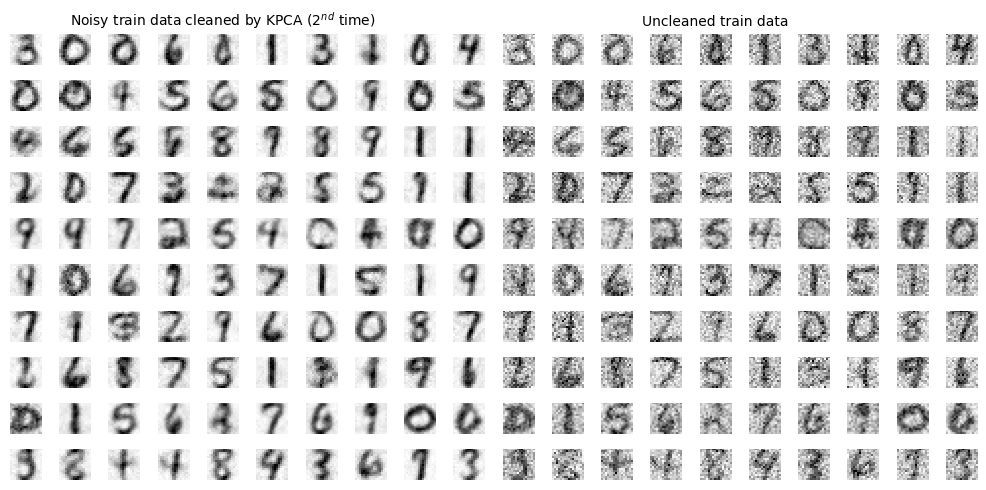

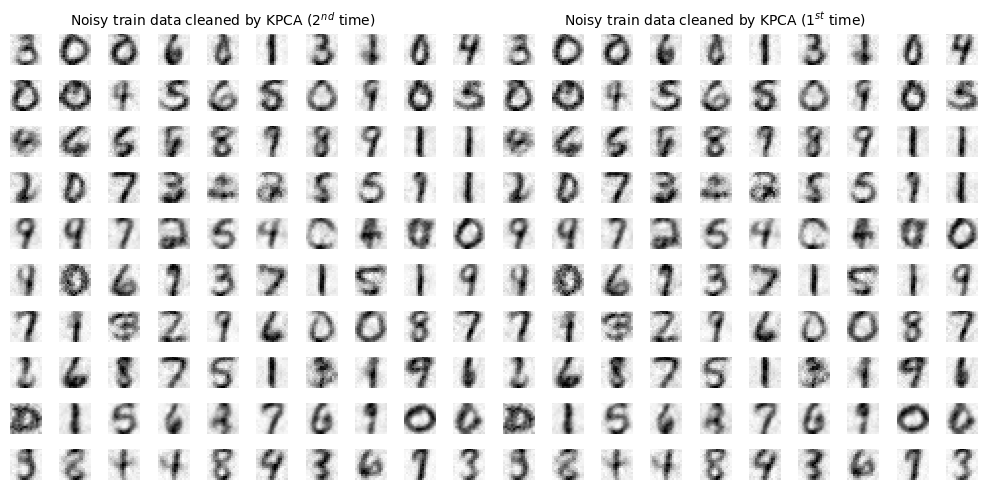

In [15]:
gamma = best_gamma_2
kernel = best_kernel_2
num_components = best_n_components_2

kpca = KernelPCA(kernel=kernel, gamma=gamma, n_components = num_components, fit_inverse_transform=True).fit(X_back_m1) 
X_kpca = kpca.transform(X_back_m1) 
X_back_m2 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m2, X_train_noisy, "Noisy train data cleaned by KPCA ($2^{nd}$ time)", "Uncleaned train data")
plot_parallel(X_back_m2, X_back_m1, "Noisy train data cleaned by KPCA ($2^{nd}$ time)", "Noisy train data cleaned by KPCA ($1^{st}$ time)")

### Tercer proceso de búsqueda de hiperparámetros

Aunque podríamos seguir así indefinidamente, iteraremos una tercera y última vez. Construiremos nuestra tercera generación de imágenes procesadas a partir de la segunda generación que obtuvimos a partir de a primera que obtuvimos a partir de las imágenes con ruido. Esta vez el barrido en `gamma` es mayor:

⚠️ ¡Atención! Ejecutar el chunk de código de abajo puede llevar a la CPU a un estado de utilización máxima.

In [16]:
from itertools import product
from joblib import Parallel, delayed

best_mse = calcular_mse(nuevas=X_back_m2)
recuento = 0
mse_lista_m3 = []

lista_gamma = np.arange(0.00125, 0.15001, 0.00125)
lista_n_components = [50, 100, 200]

results_3 = Parallel(n_jobs=-1)(delayed(evaluar_modelo)(kernel, gamma, n_components, X_back_m2)
                              for kernel, gamma, n_components in product(['rbf', 'poly'], lista_gamma, lista_n_components))

# Filtrar los resultados para excluir los valores None
results_filtered_3 = [result for result in results_3 if result is not None]

if results_filtered_3:
    
    # Encontrar el mejor resultado entre los resultados válidos
    best_result_3 = min(results_filtered_3, key=lambda x: x[3])  # Encuentra el resultado con el menor MSE
    best_kernel_3, best_gamma_3, best_n_components_3, best_mse_3 = best_result_3

    print("El mejor modelo tiene el siguiente kernel, gamma y n_components:") 
    print("Kernel:", best_kernel_3) 
    print("Gamma:", best_gamma_3) 
    print("n_components:", best_n_components_3)
    print("MSE:", best_mse_3)
else:
    print("No se encontraron resultados válidos.")

El mejor modelo tiene el siguiente kernel, gamma y n_components:
Kernel: poly
Gamma: 0.135
n_components: 100
MSE: 0.012657916493687133


Comprobamos como el mejor modelo es el último en ser probado. Ampliamos el rango de búsqueda. Habiendo probado con $\gamma \in (0, 0.15)$, ahora veremos que ocurre con $\gamma \in (0.15, 3)$.

⚠️ ¡Atención! Ejecutar el chunk de código de abajo puede llevar a la CPU a un estado de utilización máxima.

In [17]:
from itertools import product
from joblib import Parallel, delayed

best_mse = calcular_mse(nuevas=X_back_m2)
recuento = 0
mse_lista_m4 = []

lista_gamma = np.arange(0.15, 3, 0.02)
lista_n_components = [50, 100, 200]

results_4 = Parallel(n_jobs=-1)(delayed(evaluar_modelo)(kernel, gamma, n_components, X_back_m2)
                              for kernel, gamma, n_components in product(['rbf', 'poly'], lista_gamma, lista_n_components))

# Filtrar los resultados para excluir los valores None
results_filtered_4 = [result for result in results_4 if result is not None]

if results_filtered_4:
    
    # Encontrar el mejor resultado entre los resultados válidos
    best_result_4 = min(results_filtered_4, key=lambda x: x[3])  # Encuentra el resultado con el menor MSE
    best_kernel_4, best_gamma_4, best_n_components_4, best_mse_4 = best_result_4

    print("El mejor modelo tiene el siguiente kernel, gamma y n_components:") 
    print("Kernel:", best_kernel_4) 
    print("Gamma:", best_gamma_4) 
    print("n_components:", best_n_components_4)
    print("MSE:", best_mse_4)
else:
    print("No se encontraron resultados válidos.")

El mejor modelo tiene el siguiente kernel, gamma y n_components:
Kernel: poly
Gamma: 0.15
n_components: 100
MSE: 0.012658159317138236


Vemos que el mejor resultado en este nuevo dominio de `gamma` es peor que en el caso anterior, obteniéndose el mejor resultado con `gamma` = 15.

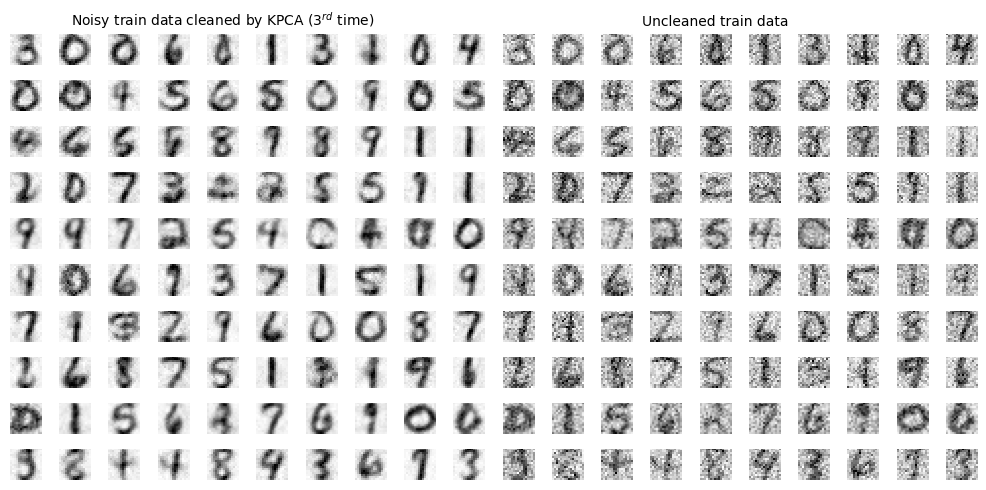

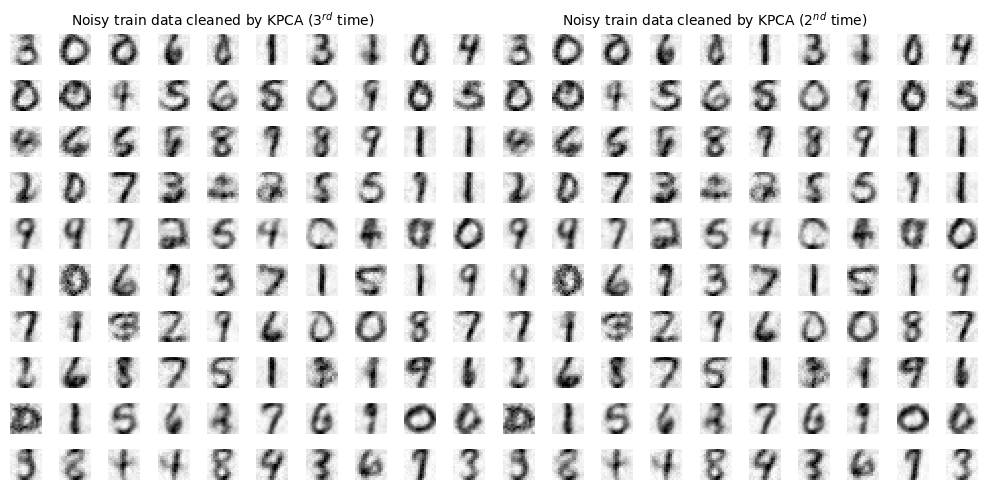

In [18]:
kernel= best_kernel_3
gamma = best_gamma_3
num_components = best_n_components_3

kpca = KernelPCA(kernel= kernel, gamma = gamma, n_components = num_components, fit_inverse_transform=True).fit(X_back_m2)
X_kpca = kpca.transform(X_back_m2)
X_back_m3 = kpca.inverse_transform(X_kpca)

plot_parallel(X_back_m3, X_train_noisy, "Noisy train data cleaned by KPCA ($3^{rd}$ time)", "Uncleaned train data")
plot_parallel(X_back_m3, X_back_m2, "Noisy train data cleaned by KPCA ($3^{rd}$ time)", "Noisy train data cleaned by KPCA ($2^{nd}$ time)")


### Evaluación de nuestros modelos entrenados en el conjunto de TEST

El salto en calidad es prácticamente imperceptible, pero valía la pena comprobar hasta dónde podíamos llegar con otra iteración más. Además, resulta interesante el haber salido de nuestro dominio inicial en `gamma` para ver si estábamos perdiendo algo de información importante.

Ahora, usando estos valores, vamos a transformar los datos de test para evaluar que tal funciona este procedimiento con datos no vistos previamente:

El MSE entre el conjunto test original y el ruidoso inicial es 0.061341634382292426
El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 1ª iteración es 0.026699994004501168


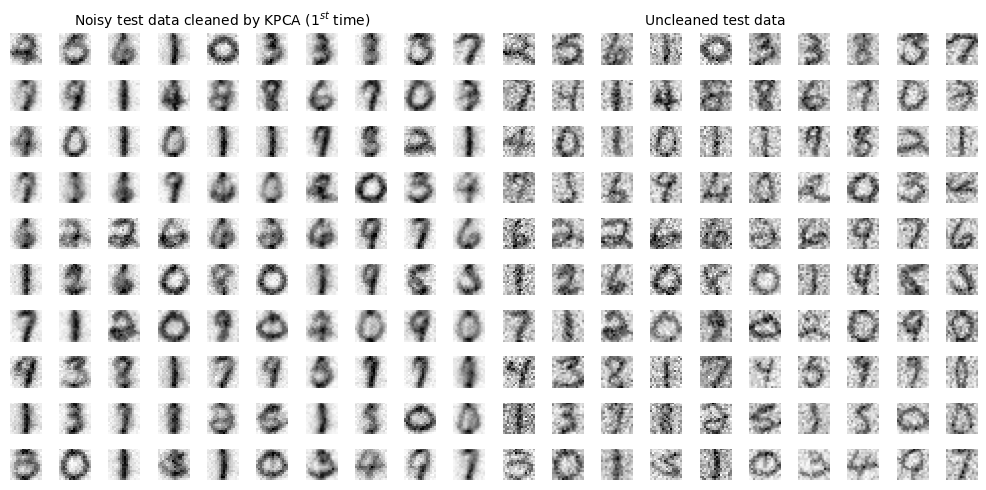

In [47]:
gamma_1 = best_gamma
kernel_1 = best_kernel
num_components_1 = best_n_components

mse_test_0 = calcular_mse(nuevas=X_test_noisy, originales=X_test)
print(f"El MSE entre el conjunto test original y el ruidoso inicial es {mse_test_0}")

kpca_1 = KernelPCA(kernel=kernel_1, gamma=gamma_1, n_components = num_components_1, random_state = rs, fit_inverse_transform=True).fit(X_test_noisy) 
X_kpca_1 = kpca_1.transform(X_test_noisy) 
X_back_m1_test = kpca_1.inverse_transform(X_kpca_1)
mse_test_1 = calcular_mse(nuevas=X_back_m1_test, originales=X_test)
print(f"El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 1ª iteración es {mse_test_1}")


plot_parallel(X_back_m1_test, X_test_noisy, "Noisy test data cleaned by KPCA ($1^{st}$ time)", "Uncleaned test data")

El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 2ª iteración es 0.027575187771138213


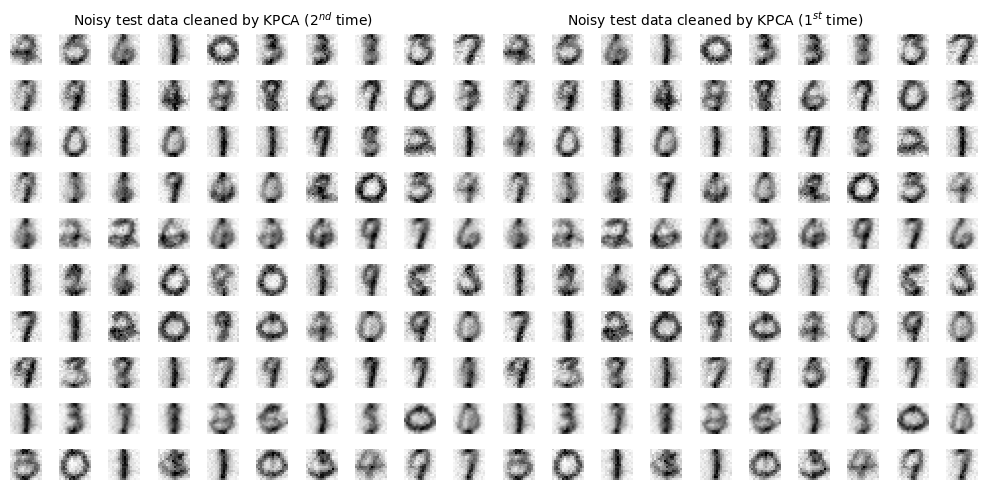

In [48]:
gamma_2 = best_gamma_2
kernel_2 = best_kernel_2
num_components_2 = best_n_components_2


kpca_2 = KernelPCA(kernel=kernel_2, gamma=gamma_2, n_components = num_components_2, random_state = rs, fit_inverse_transform=True).fit(X_back_m1_test)
X_kpca_2 = kpca_2.transform(X_back_m1_test)
X_back_m2_test = kpca_2.inverse_transform(X_kpca_2)
mse_test_2 = calcular_mse(nuevas=X_back_m2_test, originales=X_test)
print(f"El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 2ª iteración es {mse_test_2}")

plot_parallel(X_back_m2_test, X_back_m1_test, "Noisy test data cleaned by KPCA ($2^{nd}$ time)", "Noisy test data cleaned by KPCA ($1^{st}$ time)")


El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 3ª iteración es 0.027707628779357295


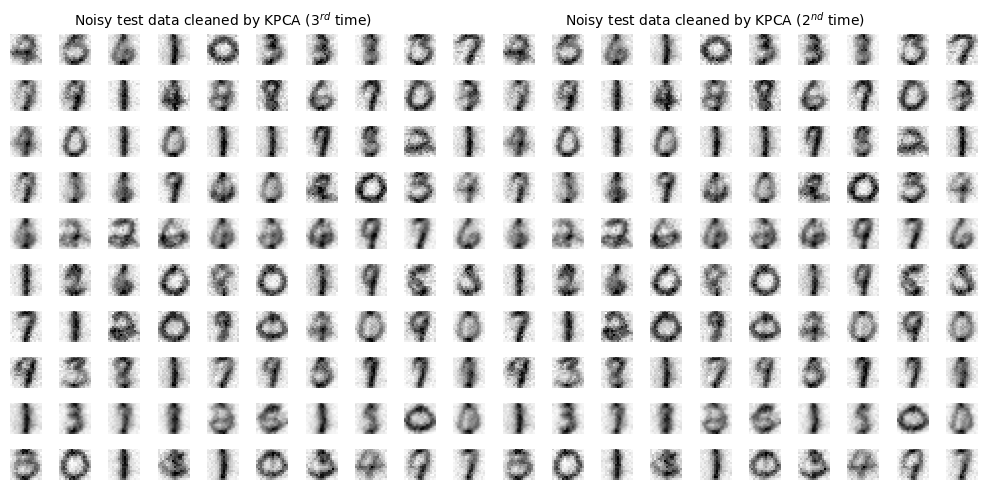

In [49]:
gamma_3 = best_gamma_3
kernel_3 = best_kernel_3
num_components_3 = best_n_components_3

kpca_3 = KernelPCA(kernel=kernel_3, gamma=gamma_3, n_components = num_components_3, random_state = rs, fit_inverse_transform=True).fit(X_back_m2_test)
X_kpca_3 = kpca_3.transform(X_back_m2_test)
X_back_m3_test = kpca_3.inverse_transform(X_kpca_3)
mse_test_3 = calcular_mse(nuevas=X_back_m3_test, originales=X_test)
print(f"El MSE entre el conjunto test ruidoso y el limpiado con KPCA en 3ª iteración es {mse_test_3}")


plot_parallel(X_back_m3_test, X_back_m1_test, "Noisy test data cleaned by KPCA ($3^{rd}$ time)", "Noisy test data cleaned by KPCA ($2^{nd}$ time)")


Desgraciadamente comrpobamos como los resultados obtenidos NO son los esperados. Veamos la evolución relativa del MSE:

#### Evolución relativa del MSE para el conjunto de test

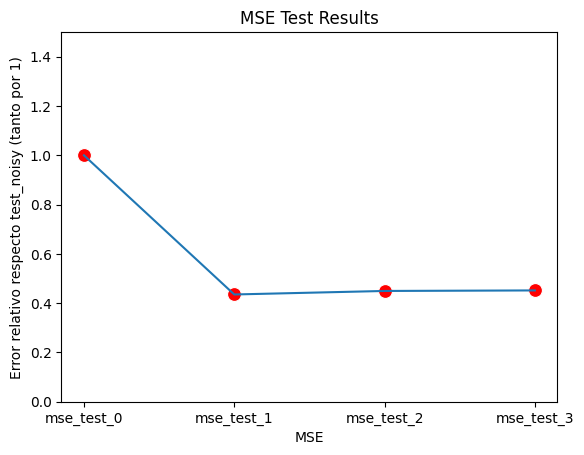

In [44]:
data = {'MSE': ['mse_test_0', 'mse_test_1', 'mse_test_2', 'mse_test_3'],
        'Value': [mse_test_0 / mse_test_0, mse_test_1 / mse_test_0, mse_test_2 / mse_test_0, mse_test_3 / mse_test_0]}
df = pd.DataFrame(data)


sns.lineplot(x='MSE', y='Value', data=df)
sns.scatterplot(x='MSE', y='Value', data=df, color='red', marker='o', s=100)  # Add individual points
plt.xlabel('MSE')
plt.ylabel('Error relativo respecto test_noisy (tanto por 1)')
plt.title('MSE Test Results')
plt.ylim(0, 1.5)  
plt.show()

Después de todo el esfuerzo invertido, no conseguimos que los datos de test mejoren tanto como los de train usando los hiperparámetros que minimizaban el MSE. Aunque después de la primera iteracción reducimos el error a algo más de la mitad, en sucesivas iteracciones no solo no disminuye, si no que además crece. 

Tendríamos que volver a barrer todos los posibles valores cambiando ligeramente gamma en cada ocasión hasta con dar con el conjunto de parámetros que soluciona el problema de forma óptima para los datos de test.

Un enfoque distinto es el siguiente: vamos a aumentar el contrase de las imágenes de forma que aquellas zonas más densas, con posibles grafos, se vean más contrastadas. Esto se realiza después de haber aplicado KPCA.

### Proceso adicional para obtener mejores resultados

In [26]:
# Función para aumentar el contraste de una imagen

def increase_contrast(image):
    # Escalar los valores de píxeles al rango [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    scaled_image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # Aplicar la ecualización del histograma
    equalized = cv2.equalizeHist(scaled_image)

    return equalized

X_contraste = increase_contrast(X_back_m1)

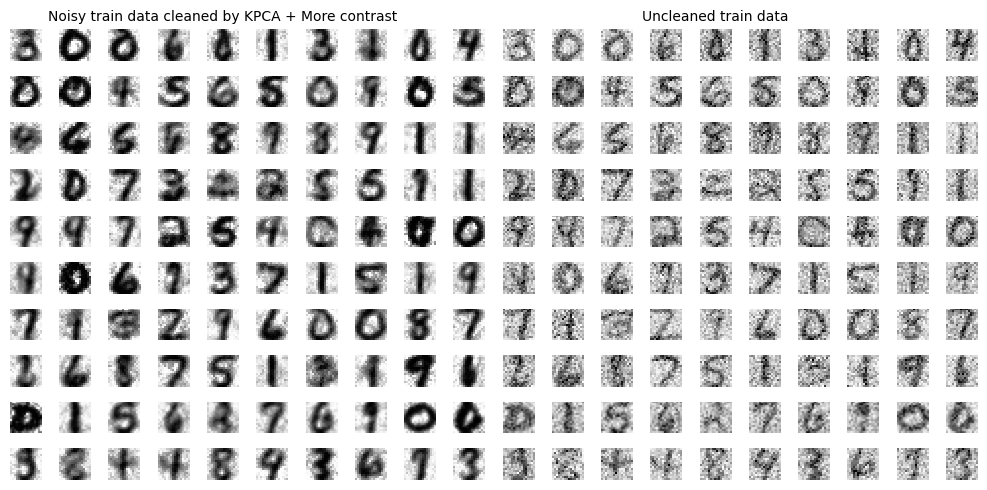

In [27]:
#X_contraste = X_contraste / 255.0
plot_parallel(X_contraste, X_train_noisy, "Noisy train data cleaned by KPCA + More contrast", "Uncleaned train data")

A continuación puede verse como son las imágenes con y sin contraste tras pasar por KPCA, en vez de una comparación directa con las imágenes con ruido.

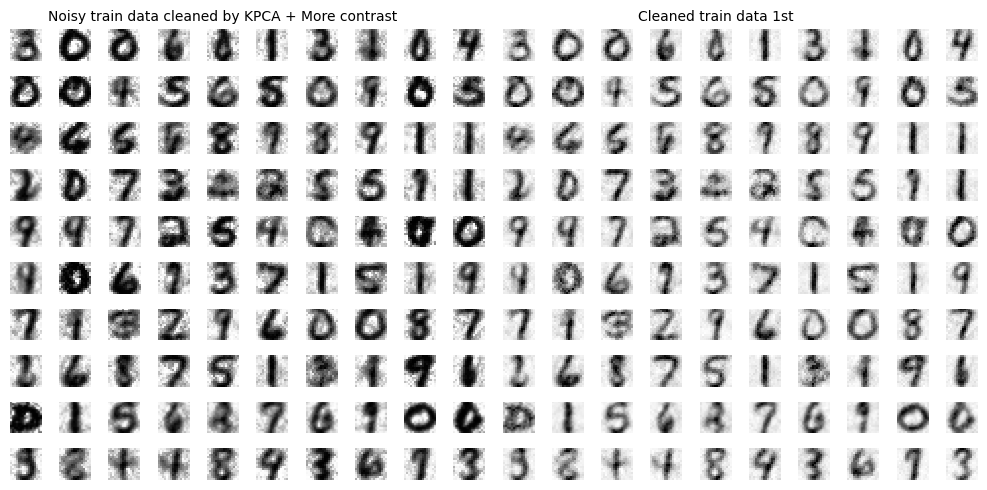

In [29]:
plot_parallel(X_contraste, X_back_m1, "Noisy train data cleaned by KPCA + More contrast", "Cleaned train data 1st")

Un posible segundo paso es eliminar toda aquella información de píxeles que se encuentren por debajo de un percentil, de forma que nos quedemos con las zonas con más información.

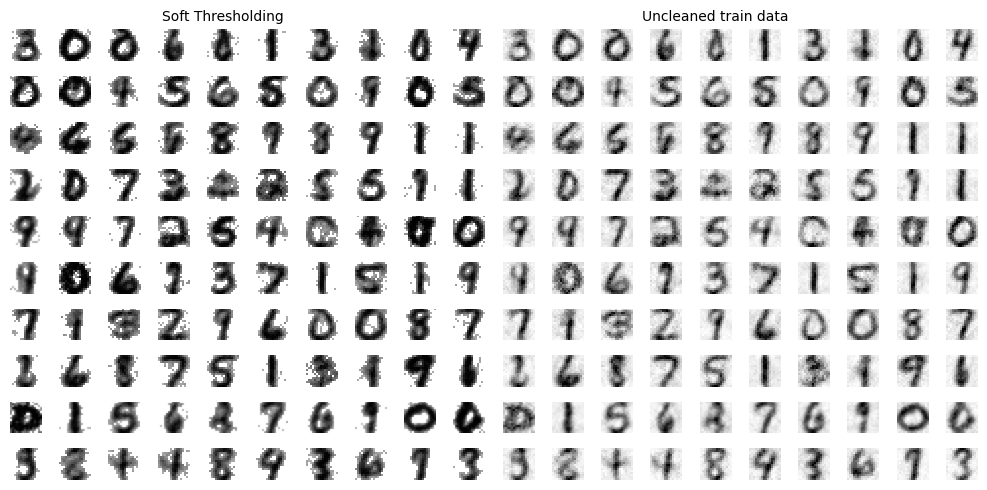

In [30]:
# Calcular el percentil 35 de valor de la imagen
percentil_35 = np.percentile(X_contraste, 40)

# Aplicar una máscara para establecer a 0 los píxeles por debajo del percentil 35
X_contraste_filtrado = np.where(X_contraste < percentil_35, 0, X_contraste)

plot_parallel(X_contraste_filtrado, X_back_m1, "Soft Thresholding", "Uncleaned train data")

X_back_2 = X_contraste_filtrado / 255.0

Podemos ser más agresivos y umbralizar de forma que solo nos quedemos con aquellos valores que tengan el 50% o más del valor máximo de intensidad. Se aprecian mejor los números pero sigue resultando un poco rudo.

In [39]:
max_value = np.max(X_contraste)

# Calcular el umbral, que es el 50 % del máximo valor
umbral = 0.5 * max_value

# Aplicar una máscara para establecer a 0 los píxeles por debajo del umbral
X_contraste_filtrado = np.where(X_contraste < umbral, 0, X_contraste)

X_back_2 = X_contraste_filtrado / 255.0

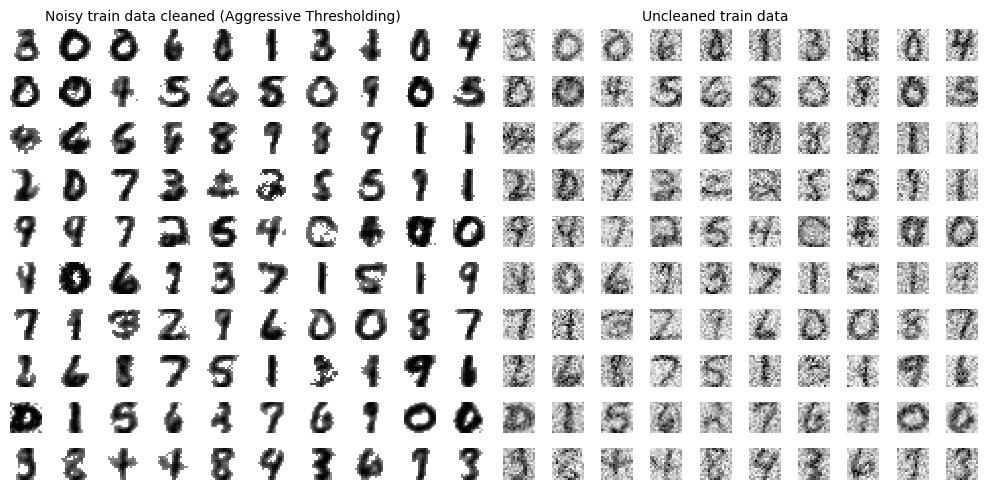

In [40]:
plot_parallel(X_back_2, X_train_noisy, "Noisy train data cleaned (Aggressive Thresholding)", "Uncleaned train data")

Nos gustaría comentar que hay más técnicas que son posibles de aplicar para limpiar los datos, usando filtrados gaussianos o transformadas Wavelets. 

Pero eso no es el objetivo de esta tarea. Aquí hemos tratado de usar la KPCA para limpiar nuestras imágenes, siendo el objetivo "familiarizarnos con el algoritmo y su funcionamiento". Tal vez se podría continuar trabajando con los datos de test, pero creo que es más relevante entender que el parámetro `gamma` es realmente delicado.